In [81]:
# Data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# Plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

# Make sure charts appear in the notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Stats/regressions packages
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Enable viewing of all columns for DataFrames
pd.set_option('display.max_columns', None)

# To ensure that XGBoost runs without causing kernel to fail
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Loading the bank dataset

filepath = './bank_data/bank-additional-full.csv'
df = pd.read_csv(filepath, delimiter=';')
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [5]:
# Converting Target variable into 1 and 0
df['y'] = df['y'].apply(lambda x: 1 if x=='yes' else 0)

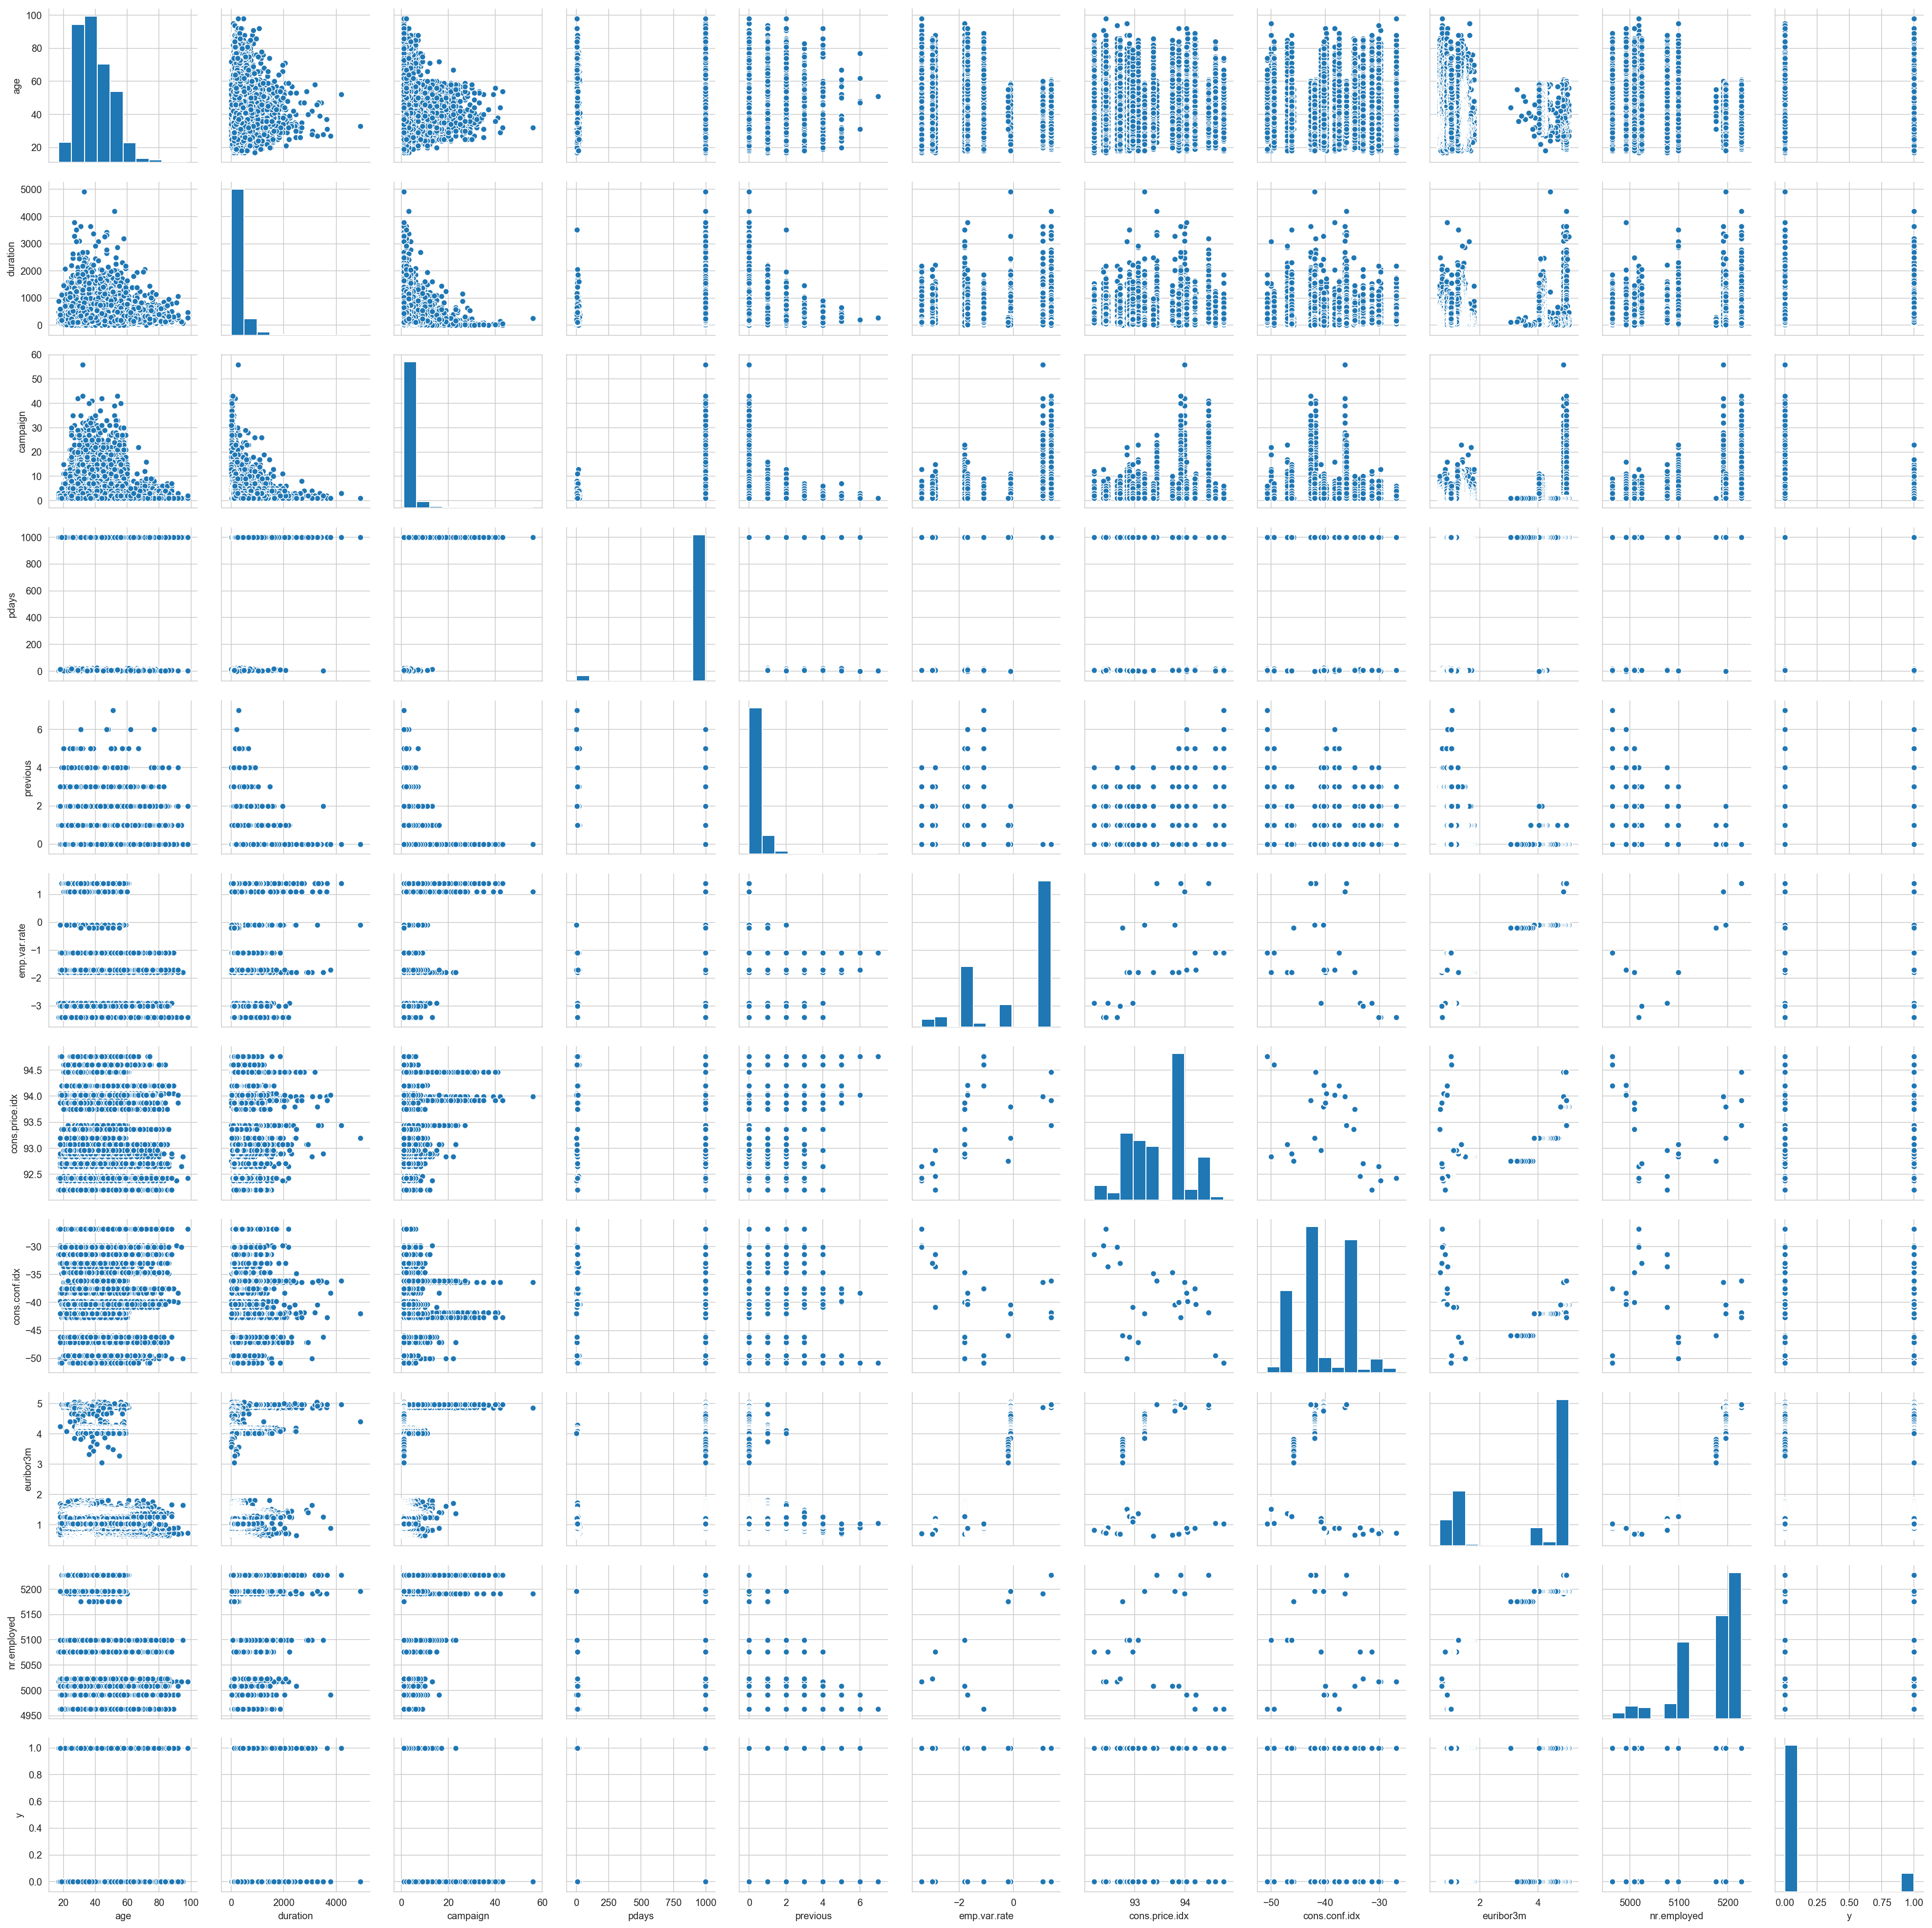

In [6]:
sns.pairplot(df)

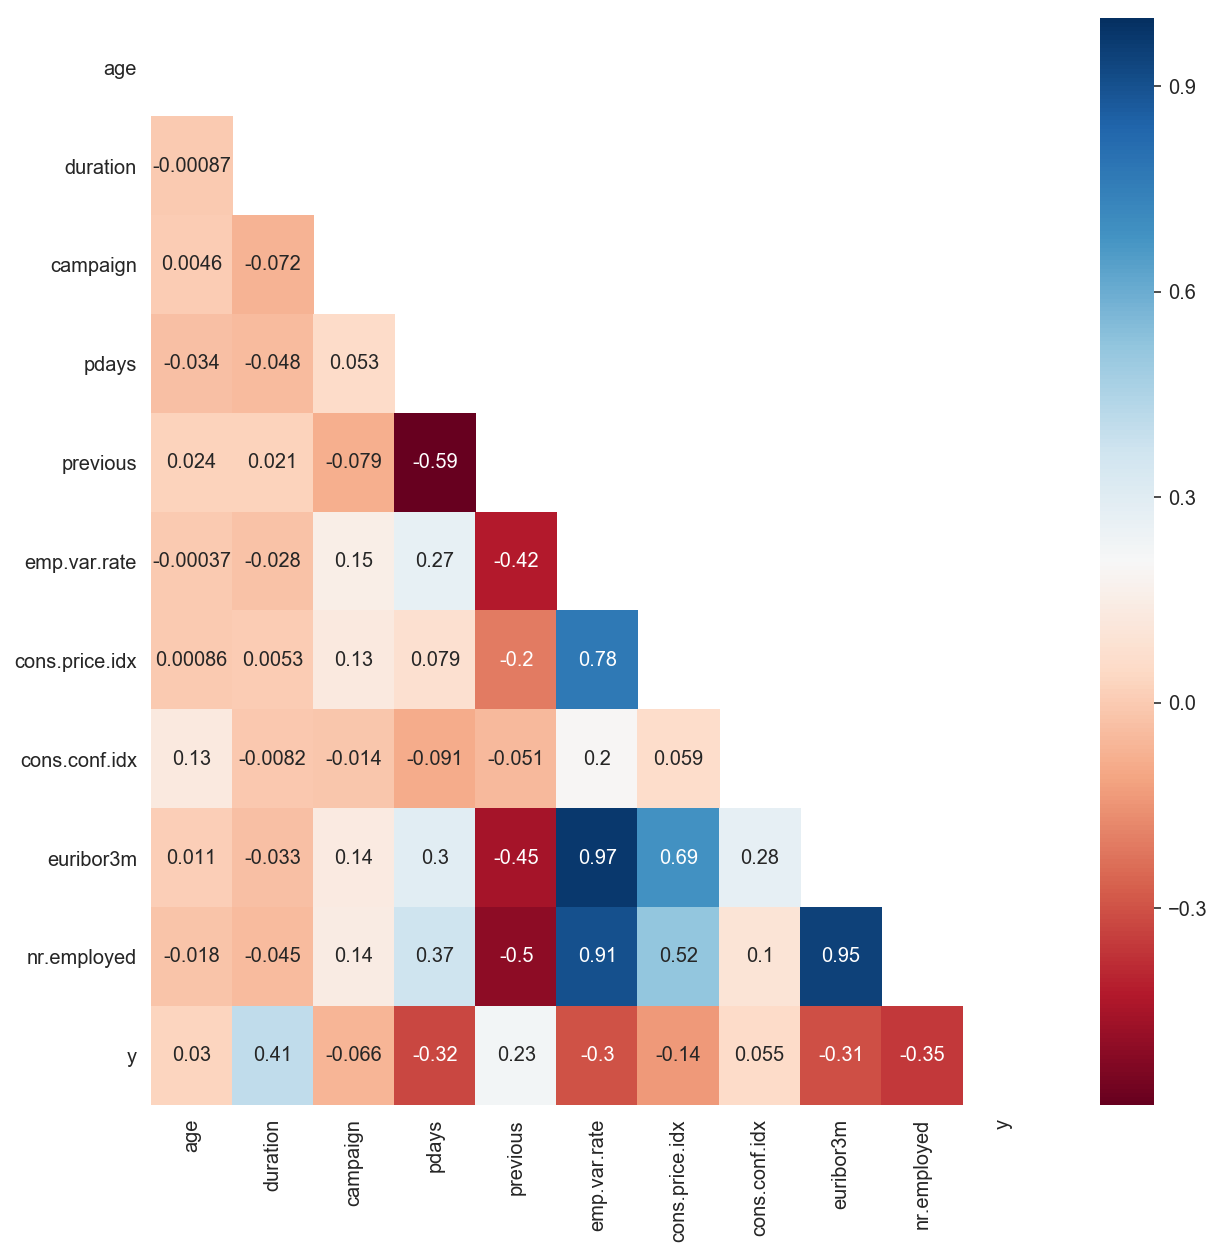

In [7]:
# Look at correlation between the variables.
df_corr = df.corr()

# Setting figure plotsize
fix, ax = plt.subplots(figsize=(10,10))

# Generate a mask for the upper triangle (taken from Seaborn's example gallery).
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with Seaborn.
ax = sns.heatmap(df_corr, annot=True, cmap='RdBu', mask=mask, ax=ax)

plt.show()

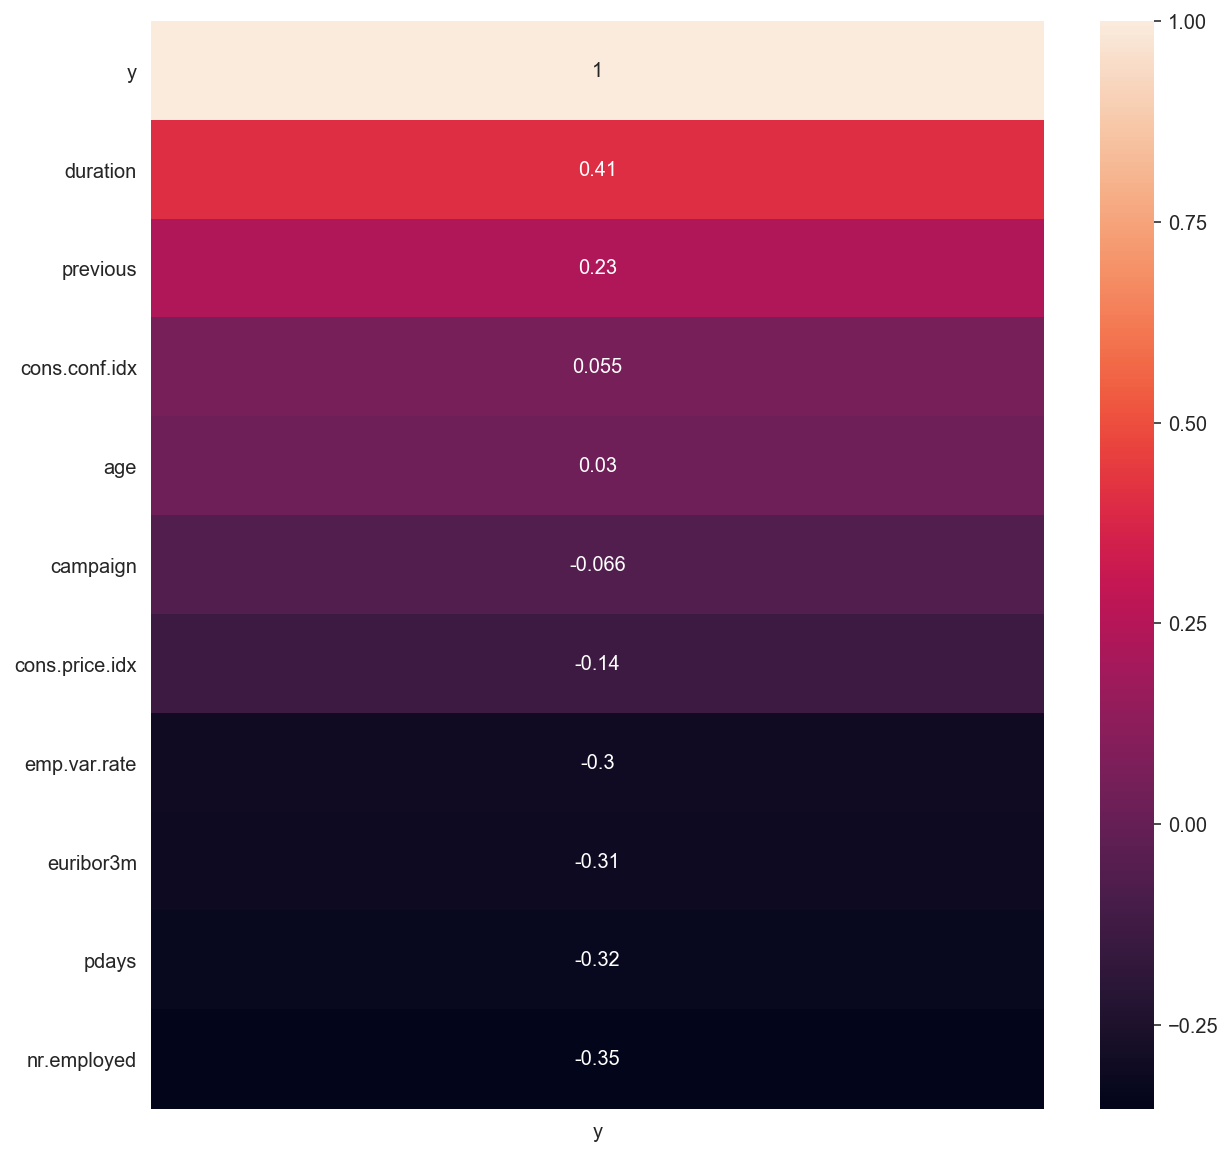

In [8]:
# Generate a heatmap to see which of the fixed features are most strongly correlated with the target variable (SalePrice)

fix, ax = plt.subplots(figsize=(10,10))

sns.heatmap(df.corr()[['y']].sort_values(by='y', ascending=False), annot=True)
plt.show()

In [9]:
df['y'].value_counts(normalize=True) * 100

0    88.734583
1    11.265417
Name: y, dtype: float64

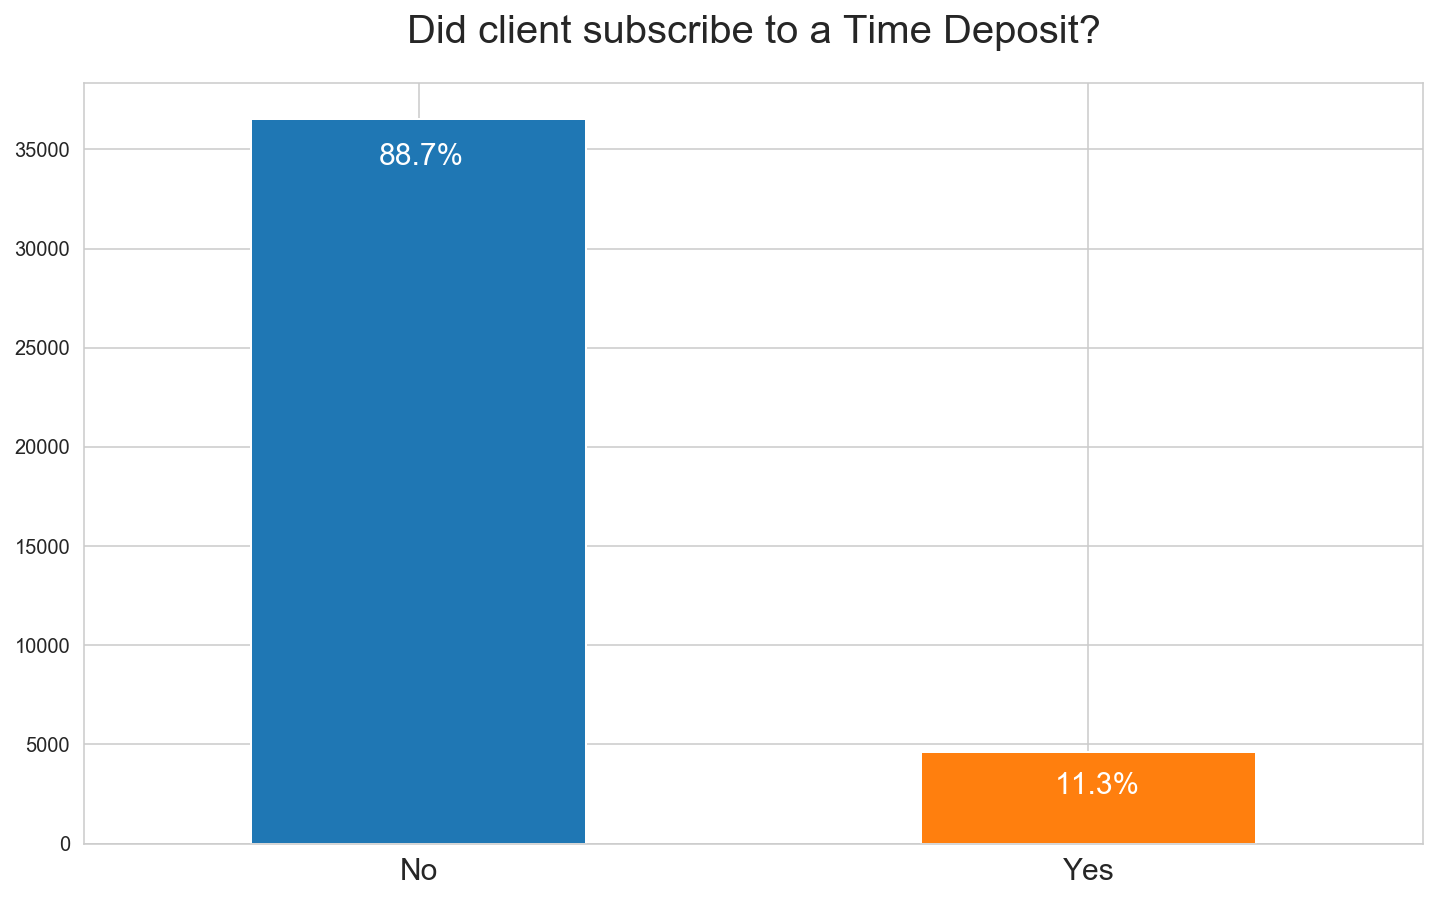

In [74]:
plt.figure(figsize=(12,7))
plt.grid(False)
df['y'].value_counts().plot(kind='bar')
plt.title('Did client subscribe to a Time Deposit?', fontsize=20, pad=20)
plt.xticks(np.arange(2), ('No', 'Yes'), rotation=0, fontsize=15)
plt.annotate('88.7%', xy=(-0.06, 34200), fontsize=15, color='w')
plt.annotate('11.3%', xy=(0.95, 2500), fontsize=15, color='w')
plt.show()

In [23]:
# Assigning data to target and feature variables
y = df['y']

# Creating a benchmark dataset to see the impact of having the current campaign data
Xb = df.drop(columns='y')

# Creating dataset for features & dropping the current campaign data
# This would give us a more realistic model for selecting customers for the current campaign
X = df.drop(columns=['y', 'contact', 'month', 'day_of_week', 'duration', 'campaign'])

In [24]:
X.describe()

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [25]:
dummy = []
for col in X.columns:
    if X[col].dtype == 'O':
        dummy.append(col)

b_dummy = []
for col in Xb.columns:
    if Xb[col].dtype == 'O':
        b_dummy.append(col)

In [26]:
# One-hot encoding for non-numerical features

X = pd.concat([X, pd.get_dummies(X[dummy], drop_first=True)], axis=1)
X.drop(columns=dummy, inplace=True)
print(X.shape)

Xb = pd.concat([Xb, pd.get_dummies(Xb[b_dummy], drop_first=True)], axis=1)
Xb.drop(columns=b_dummy, inplace=True)
print(Xb.shape)

(41188, 37)
(41188, 53)


In [27]:
# Applying Train-Test Split on the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, y, random_state=42, stratify=y)

# Applying Standard Scaler
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

Xs_train = pd.DataFrame(Xs_train, columns=X_train.columns)
Xs_test = pd.DataFrame(Xs_test, columns=X_test.columns)

Xbs_train = ss.fit_transform(Xb_train)
Xbs_test = ss.transform(Xb_test)

Xbs_train = pd.DataFrame(Xbs_train, columns=Xb_train.columns)
Xbs_test = pd.DataFrame(Xbs_test, columns=Xb_test.columns)

# Checking baseline accuracy
baseline = 1 - np.mean(y_train)
print("Baseline:", baseline)

Baseline: 0.8873458288821987


In [163]:
# Function to help find the best classification model via GridSearchCV
# cross_val_score & roc_auc_score are also printed


def classifier_check(name, model, params, Xtrain, ytrain, Xtest, ytest, scoring='accuracy', folds=5):
    '''
    Function takes a model, applies the parameters setup for GridSearchCV
    Prints the relevant scoring metric & scores on the best model
    Returns the best model (ie, best_estimator_)
    '''

    temp = GridSearchCV(model, params, scoring=scoring).fit(Xtrain, ytrain)
    temp_model = temp.best_estimator_

    scores = cross_val_score(temp_model, Xtrain, ytrain, cv=folds, scoring=scoring)

    print("=====" * 10)
    print("{}-Fold Cross Validated Results for {}:".format(folds, name))
    print("Scoring metric:", scoring)
    print()
    print("Cross-validated scores:", scores)
    print("Mean score:", np.mean(scores))
    print("Std score:", np.std(scores))
    print()
    print("{} AUC score:".format(name), roc_auc_score(ytest, temp_model.predict_proba(Xtest)[:, 1]))

    return temp_model


# Function to help find the best features via recursive feature elimination RFE


def feature_select(model, x, y, step=1):
    '''
    Function takes a model, applies RFE on the x & y
    Prints the features with their respective support and ranking
    Returns a list of features where support == True
    '''

    selector = RFE(model, step=step)
    selector = selector.fit(x, y)

    df_select = pd.DataFrame({"Feature": x.columns, "Support": selector.support_, "Ranking": selector.ranking_})

    print(df_select.sort_values(by="Ranking", ascending=True).head())

    return list(df_select[df_select["Support"] == True]["Feature"])


# Function to create confusion matrix based on a specified threshold/cutoff

def threshold_matrix(model, x, y, threshold=0.5):
    '''
    Function takes a trained model to create a confusion matrix based on a specified threshold or cutoff
    Returns a DataFrame of the confusion matrix
    '''

    temp_df = pd.DataFrame({"Probability": model.predict_proba(x)[:, 1], "y_act": y})
    temp_df['y_pred'] = temp_df['Probability'].apply(lambda x: 1 if x > threshold else 0)
    
    precision = temp_df[temp_df['y_act'] == 1]['y_pred'].sum()/temp_df['y_pred'].sum()
    recall = temp_df[temp_df['y_pred'] == 1]['y_act'].sum()/temp_df['y_act'].sum()
    
    print("Precision based on threshold of {}: {}".format(threshold, precision))
    print("Recall based on threshold of {}: {}".format(threshold, recall))
    
    return pd.crosstab(temp_df['y_act'], temp_df['y_pred'], rownames=['Actual'], colnames=['Predicted'])

In [17]:
# Setting up GridSearchCV parameters for the various models

# Random Forest
rf_params = {
    'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features':['auto', 'sqrt'],
    'n_estimators':[50, 100, 150, 200, 250],
    'criterion':['gini', 'entropy']
}

# Logistic Regression
logr_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-4, 4, 20),
    'class_weight':[None, 'balanced']
}

# K-Nearest Neighbor
knn_params = {
    'n_neighbors':range(15, 51, 2),
    'weights':['distance','uniform']
}

# XGBoost
xgb_params = {
    'learning_rate':np.linspace(0.3, 0.1, 5),
    'max_depth':[6, 7, 8, 9],
    'gamma':np.linspace(0.1, 0.5, 5),
    'min_child_weight':[1, 3, 5],
}

In [18]:
# Applying GridSearchCV to find the parameters for the 4 models for selection based on the benchmark dataset

rf_bench = classifier_check("Random Forest (Benchmark)", RandomForestClassifier(), rf_params, Xb_train, yb_train, Xb_test, yb_test, scoring="roc_auc")
logr_bench = classifier_check("Logistic Regression (Benchmark)", LogisticRegression(), logr_params, Xb_train, yb_train, Xb_test, yb_test, scoring="roc_auc")
knn_bench = classifier_check("K-Nearest Neighbor (Benchmark)", KNeighborsClassifier(), knn_params, Xbs_train, yb_train, Xbs_test, yb_test, scoring="roc_auc")
xgb_bench = classifier_check("XGBoost (Benchmark)", XGBClassifier(), xgb_params, Xbs_train, yb_train, Xbs_test, yb_test, scoring="roc_auc")

5-Fold Cross Validated Results for Random Forest (Benchmark):
Scoring metric: roc_auc

Cross-validated scores: [0.94485502 0.94791968 0.94178898 0.94207191 0.94294546]
Mean score: 0.9439162117245056
Std score: 0.0022705958438744224

Random Forest (Benchmark) AUC score: 0.9498965932378014
5-Fold Cross Validated Results for Logistic Regression (Benchmark):
Scoring metric: roc_auc

Cross-validated scores: [0.94012187 0.93904136 0.93011533 0.9333     0.93487175]
Mean score: 0.9354900612651761
Std score: 0.003691389395334698

Logistic Regression (Benchmark) AUC score: 0.9428395534639379
5-Fold Cross Validated Results for K-Nearest Neighbor (Benchmark):
Scoring metric: roc_auc

Cross-validated scores: [0.88666537 0.89087825 0.88794912 0.88720111 0.88268752]
Mean score: 0.8870762716070051
Std score: 0.0026329631054826893

K-Nearest Neighbor (Benchmark) AUC score: 0.904302891237975
5-Fold Cross Validated Results for XGBoost (Benchmark):
Scoring metric: roc_auc

Cross-validated scores: [0.94940

In [28]:
# Extracting Feature importances from XGBoost model with RFE

df_bench_impt = pd.DataFrame(xgb_bench_feat.feature_importances_, index=[xgb_bench_feature])
df_bench_impt.rename(columns={0:'Feature Importance'},inplace=True)
df_bench_impt.sort_values(by=['Feature Importance'], ascending=False, inplace=True)
df_bench_impt.head(20)

,Feature Importance
duration,0.270206
euribor3m,0.175962
age,0.139427
campaign,0.061587
cons.price.idx,0.045482
cons.conf.idx,0.035789
pdays,0.031613
emp.var.rate,0.023710
previous,0.021324
education_university.degree,0.018789


## <span style="color:steelblue"> Analysis of the Models based on the Benchmark </span>

Looking at the benchmark models, the best is with XGBoost with reduced features via RFE with an AUC score of 0.952 on the test data. The interesting thing to note is that the top features in terms of importance is occupied mainly by **socio-economic** data. The other important feature besides the current campaign information is **age**.

In [29]:
# Applying GridSearchCV to find the parameters for the 4 models for selection

rf_clf = classifier_check("Random Forest", RandomForestClassifier(), rf_params, X_train, y_train, X_test, y_test, scoring="roc_auc")
logr_clf = classifier_check("Logistic Regression", LogisticRegression(), logr_params, X_train, y_train, X_test, y_test, scoring="roc_auc")
knn_clf = classifier_check("K-Nearest Neighbor", KNeighborsClassifier(), knn_params, Xs_train, y_train, Xs_test, y_test, scoring="roc_auc")
xgb_clf = classifier_check("XGBoost", XGBClassifier(), xgb_params, Xs_train, y_train, Xs_test, y_test, scoring="roc_auc")

5-Fold Cross Validated Results for Random Forest:
Scoring metric: roc_auc

Cross-validated scores: [0.77660522 0.79217289 0.80038367 0.80128618 0.77874598]
Mean score: 0.7898387923048529
Std score: 0.0104485702571951

Random Forest AUC score: 0.8071879493382346
5-Fold Cross Validated Results for Logistic Regression:
Scoring metric: roc_auc

Cross-validated scores: [0.75381299 0.7522148  0.77598198 0.7703292  0.75628232]
Mean score: 0.761724255670641
Std score: 0.009591249476882795

Logistic Regression AUC score: 0.7824304268736815
5-Fold Cross Validated Results for K-Nearest Neighbor:
Scoring metric: roc_auc

Cross-validated scores: [0.75126462 0.7524419  0.77052485 0.76859573 0.73452315]
Mean score: 0.7554700503541849
Std score: 0.01314959114434594

K-Nearest Neighbor AUC score: 0.7643074483060537
5-Fold Cross Validated Results for XGBoost:
Scoring metric: roc_auc

Cross-validated scores: [0.78084875 0.79382053 0.79866174 0.79982437 0.77835993]
Mean score: 0.7903030623352653
Std score

In [31]:
# Applying RFE to see if by reducing the number of features we get better scores

rf_clf_feature = feature_select(rf_clf, X_train, y_train)
logr_clf_feature = feature_select(logr_clf, X_train, y_train)
xgb_clf_feature = feature_select(xgb_clf, Xs_train, y_train)

# Applying GridSearchCV with the selected features on the 4 models
rf_clf_feat = classifier_check("Random Forest w/ RFE", RandomForestClassifier(), rf_params, X_train[rf_clf_feature], y_train, X_test[rf_clf_feature], y_test, scoring="roc_auc")
logr_clf_feat = classifier_check("Logistic Regression w/ RFE", LogisticRegression(), logr_params, X_train[logr_clf_feature], y_train, X_test[logr_clf_feature], y_test, scoring="roc_auc")
xgb_clf_feat = classifier_check("XGBoost w/ RFE", XGBClassifier(), xgb_params, Xs_train[xgb_clf_feature], y_train, Xs_test[xgb_clf_feature], y_test, scoring="roc_auc")

                        Feature  Support  Ranking
0                           age     True        1
34                     loan_yes     True        1
32                  housing_yes     True        1
29              default_unknown     True        1
27  education_university.degree     True        1
                          Feature  Support  Ranking
36               poutcome_success     True        1
20                 marital_single     True        1
35           poutcome_nonexistent     True        1
26  education_professional.course     True        1
27    education_university.degree     True        1
                          Feature  Support  Ranking
0                             age     True        1
20                 marital_single     True        1
19                marital_married     True        1
26  education_professional.course     True        1
27    education_university.degree     True        1
5-Fold Cross Validated Results for Random Forest w/ RFE:
Scoring metric: roc

In [32]:
# Extracting Feature importances from Random Forest model with RFE

df_clf_impt = pd.DataFrame(rf_clf_feat.feature_importances_, index=[rf_clf_feature])
df_clf_impt.rename(columns={0:'Feature Importance'},inplace=True)
df_clf_impt.sort_values(by=['Feature Importance'], ascending=False, inplace=True)
df_clf_impt.head(20)

,Feature Importance
euribor3m,0.220183
nr.employed,0.175413
pdays,0.119373
age,0.089744
poutcome_success,0.072817
cons.conf.idx,0.071362
emp.var.rate,0.059436
cons.price.idx,0.057363
previous,0.025680
poutcome_nonexistent,0.015312


## <span style="color:steelblue"> Analysis of the Models based on data without campaign details </span>

With the removal of the current campaign data, the ability of the model to be able to predict the subscription of a TD also drops. The best model that we were able to obtain was using a Random Forest classifier with features selected via RFE. The AUC score obtain was 0.8132 on the test dataset.

Once again, it is interesting to note that among the top important features, **socio-economic data** dominates. However, now with the loss of the current campaign data, in addition to **age** the **previous campaign data** has also moved up in terms of importance.

In [58]:
# Setting the features into separate groups

bank_data = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
ccampaign_data = ['contact', 'month', 'day_of_week', 'duration', 'campaign']
pcampaign_data = ['pdays', 'previous', 'poutcome']
socecon_data = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

bank_ = [c for c in Xb.columns for n in bank_data if n in c]
ccampaign_ = [c for c in Xb.columns for n in ccampaign_data if n in c]
pcampaign_ = [c for c in Xb.columns for n in pcampaign_data if n in c]
socecon_ = [c for c in Xb.columns for n in socecon_data if n in c]

# Removing the additional 'job_management' in the bank_ list due to 'age' picking it up as well
bank_.remove('job_management')

# Creating datasets for the various groups

Xbank_train, Xbanks_train, Xbank_test, Xbanks_test = Xb_train[bank_], Xbs_train[bank_], Xb_test[bank_], Xbs_test[bank_]
Xccampaign_train, Xccampaigns_train, Xccampaign_test, Xccampaigns_test = Xb_train[ccampaign_], Xbs_train[ccampaign_], Xb_test[ccampaign_], Xbs_test[ccampaign_]
Xpcampaign_train, Xpcampaigns_train, Xpcampaign_test, Xpcampaigns_test = Xb_train[pcampaign_], Xbs_train[pcampaign_], Xb_test[pcampaign_], Xbs_test[pcampaign_]
Xsocecon_train, Xsocecons_train, Xsocecon_test, Xsocecons_test = Xb_train[socecon_], Xbs_train[socecon_], Xb_test[socecon_], Xbs_test[socecon_]

In [64]:
# Applying GridSearchCV to find the parameters for the 4 models for selection on Bank Data

rf_bank = classifier_check("Random Forest for Bank Data", RandomForestClassifier(), rf_params, Xbank_train, y_train, Xbank_test, y_test, scoring="roc_auc")
logr_bank = classifier_check("Logistic Regression for Bank Data", LogisticRegression(), logr_params, Xbank_train, y_train, Xbank_test, y_test, scoring="roc_auc")
knn_bank = classifier_check("K-Nearest Neighbor for Bank Data", KNeighborsClassifier(), knn_params, Xbanks_train, y_train, Xbanks_test, y_test, scoring="roc_auc")
xgb_bank = classifier_check("XGBoost for Bank Data", XGBClassifier(), xgb_params, Xbanks_train, y_train, Xbanks_test, y_test, scoring="roc_auc")

5-Fold Cross Validated Results for Random Forest for Bank Data:
Scoring metric: roc_auc

Cross-validated scores: [0.65446896 0.65683355 0.6640949  0.6693603  0.66128607]
Mean score: 0.6612087568512746
Std score: 0.005279221213187089

Random Forest for Bank Data AUC score: 0.665976297585037
5-Fold Cross Validated Results for Logistic Regression for Bank Data:
Scoring metric: roc_auc

Cross-validated scores: [0.63439922 0.64032602 0.65021143 0.66150662 0.64872197]
Mean score: 0.6470330516456864
Std score: 0.009241610160070385

Logistic Regression for Bank Data AUC score: 0.6561097734486154
5-Fold Cross Validated Results for K-Nearest Neighbor for Bank Data:
Scoring metric: roc_auc

Cross-validated scores: [0.61990575 0.62875327 0.62445223 0.63485094 0.63384858]
Mean score: 0.6283621552245948
Std score: 0.005641921997238242

K-Nearest Neighbor for Bank Data AUC score: 0.6347293403478845
5-Fold Cross Validated Results for XGBoost for Bank Data:
Scoring metric: roc_auc

Cross-validated scor

In [65]:
# Applying GridSearchCV to find the parameters for the 4 models for selection on Current Campaign Data

rf_ccampaign = classifier_check("Random Forest for Current Campaign Data", RandomForestClassifier(), rf_params, Xccampaign_train, y_train, Xccampaign_test, y_test, scoring="roc_auc")
logr_ccampaign = classifier_check("Logistic Regression for Current Campaign Data", LogisticRegression(), logr_params, Xccampaign_train, y_train, Xccampaign_test, y_test, scoring="roc_auc")
knn_ccampaign = classifier_check("K-Nearest Neighbor for Current Campaign Data", KNeighborsClassifier(), knn_params, Xccampaigns_train, y_train, Xccampaigns_test, y_test, scoring="roc_auc")
xgb_ccampaign = classifier_check("XGBoost for Current Campaign Data", XGBClassifier(), xgb_params, Xccampaigns_train, y_train, Xccampaigns_test, y_test, scoring="roc_auc")

5-Fold Cross Validated Results for Random Forest for Current Campaign Data:
Scoring metric: roc_auc

Cross-validated scores: [0.90803877 0.90444524 0.89238658 0.89145956 0.90025978]
Mean score: 0.8993179876573857
Std score: 0.006527282401738519

Random Forest for Current Campaign Data AUC score: 0.9050883486241994
5-Fold Cross Validated Results for Logistic Regression for Current Campaign Data:
Scoring metric: roc_auc

Cross-validated scores: [0.89516643 0.89243126 0.87471891 0.87697485 0.88723833]
Mean score: 0.8853059576462338
Std score: 0.008163650638410307

Logistic Regression for Current Campaign Data AUC score: 0.8930407532088175
5-Fold Cross Validated Results for K-Nearest Neighbor for Current Campaign Data:
Scoring metric: roc_auc

Cross-validated scores: [0.89662117 0.89327651 0.88177125 0.877929   0.88952638]
Mean score: 0.8878248589778037
Std score: 0.0069937828731981054

K-Nearest Neighbor for Current Campaign Data AUC score: 0.8967721711268697
5-Fold Cross Validated Result

In [66]:
# Applying GridSearchCV to find the parameters for the 4 models for selection on Previous Campaign Data

rf_pcampaign = classifier_check("Random Forest for Previous Campaign Data", RandomForestClassifier(), rf_params, Xpcampaign_train, y_train, Xpcampaign_test, y_test, scoring="roc_auc")
logr_pcampaign = classifier_check("Logistic Regression for Previous Campaign Data", LogisticRegression(), logr_params, Xpcampaign_train, y_train, Xpcampaign_test, y_test, scoring="roc_auc")
knn_pcampaign = classifier_check("K-Nearest Neighbor for Previous Campaign Data", KNeighborsClassifier(), knn_params, Xpcampaigns_train, y_train, Xpcampaigns_test, y_test, scoring="roc_auc")
xgb_pcampaign = classifier_check("XGBoost for Previous Campaign Data", XGBClassifier(), xgb_params, Xpcampaigns_train, y_train, Xpcampaigns_test, y_test, scoring="roc_auc")

5-Fold Cross Validated Results for Random Forest for Previous Campaign Data:
Scoring metric: roc_auc

Cross-validated scores: [0.60820344 0.62372703 0.61271764 0.61663367 0.61603505]
Mean score: 0.6154633654974646
Std score: 0.005103529273304581

Random Forest for Previous Campaign Data AUC score: 0.608543511980466
5-Fold Cross Validated Results for Logistic Regression for Previous Campaign Data:
Scoring metric: roc_auc

Cross-validated scores: [0.60938971 0.6251853  0.61272105 0.6181918  0.61739268]
Mean score: 0.6165761072162927
Std score: 0.005364722911256086

Logistic Regression for Previous Campaign Data AUC score: 0.610247176127379
5-Fold Cross Validated Results for K-Nearest Neighbor for Previous Campaign Data:
Scoring metric: roc_auc

Cross-validated scores: [0.60949911 0.59902353 0.6127466  0.61817673 0.61739242]
Mean score: 0.6113676781598381
Std score: 0.006934431782429928

K-Nearest Neighbor for Previous Campaign Data AUC score: 0.6102669422922335
5-Fold Cross Validated Res

In [67]:
# Applying GridSearchCV to find the parameters for the 4 models for selection on Socio-Economic Data

rf_socecon = classifier_check("Random Forest for Socio-Economic Data", RandomForestClassifier(), rf_params, Xsocecon_train, y_train, Xsocecon_test, y_test, scoring="roc_auc")
logr_socecon = classifier_check("Logistic Regression for Socio-Economic Data", LogisticRegression(), logr_params, Xsocecon_train, y_train, Xsocecon_test, y_test, scoring="roc_auc")
knn_socecon = classifier_check("K-Nearest Neighbor for Socio-Economic Data", KNeighborsClassifier(), knn_params, Xsocecons_train, y_train, Xsocecons_test, y_test, scoring="roc_auc")
xgb_socecon = classifier_check("XGBoost for Socio-Economic Data", XGBClassifier(), xgb_params, Xsocecons_train, y_train, Xsocecons_test, y_test, scoring="roc_auc")

5-Fold Cross Validated Results for Random Forest for Socio-Economic Data:
Scoring metric: roc_auc

Cross-validated scores: [0.78175266 0.79567639 0.80203707 0.79989488 0.77157256]
Mean score: 0.790186713473243
Std score: 0.011682773072957875

Random Forest for Socio-Economic Data AUC score: 0.798433944213184
5-Fold Cross Validated Results for Logistic Regression for Socio-Economic Data:
Scoring metric: roc_auc

Cross-validated scores: [0.73938975 0.73814432 0.7635286  0.74925815 0.73518597]
Mean score: 0.7451013601847757
Std score: 0.010355480379420662

Logistic Regression for Socio-Economic Data AUC score: 0.7660075743566325
5-Fold Cross Validated Results for K-Nearest Neighbor for Socio-Economic Data:
Scoring metric: roc_auc

Cross-validated scores: [0.77214604 0.76967397 0.79487767 0.78305895 0.74885532]
Mean score: 0.7737223906430362
Std score: 0.015309886366841

K-Nearest Neighbor for Socio-Economic Data AUC score: 0.7857844006747857
5-Fold Cross Validated Results for XGBoost for 

## <span style="color:steelblue"> Analysis of the Models based on the 4 data groups </span>

Expectedly, the model based on the current campaign data is able to give us a very good AUC score of 0.9054 using XGBoost.

However, surprisingly the model that was based purely on the socio-economic data was able to give a good AUC score of 0.8040 using XGBoost. This is very comparable to the previous model where all the features (excluding current campaign data) was used (Random Forest, AUC: 0.8132.


In [69]:
print("Number of bank data features:", len(bank_))
print("Number of previous campaign data features:", len(pcampaign_))
print("Number of socio-economic data features:", len(socecon_))

Number of bank data features: 28
Number of previous campaign data features: 4
Number of socio-economic data features: 5


In [75]:
# Applying RFE to see if by reducing the number of features we get better scores for the bank data
# Best model with full feature dataset is Random Forest with AUC score of 0.6660 on test dataset

rf_bank_feature = feature_select(rf_bank, Xbank_train, y_train)
logr_bank_feature = feature_select(logr_bank, Xbank_train, y_train)
xgb_bank_feature = feature_select(xgb_bank, Xbanks_train, y_train)

# Applying GridSearchCV with the selected features on the 4 models
rf_bank_feat = classifier_check("Random Forest for Bank Data w/ RFE", RandomForestClassifier(), rf_params, Xbank_train[rf_bank_feature], y_train, Xbank_test[rf_bank_feature], y_test, scoring="roc_auc")
logr_bank_feat = classifier_check("Logistic Regression for Bank Data w/ RFE", LogisticRegression(), logr_params, Xbank_train[logr_bank_feature], y_train, Xbank_test[logr_bank_feature], y_test, scoring="roc_auc")
xgb_bank_feat = classifier_check("XGBoost for Bank Data w/ RFE", XGBClassifier(), xgb_params, Xbanks_train[xgb_bank_feature], y_train, Xbanks_test[xgb_bank_feature], y_test, scoring="roc_auc")

                        Feature  Support  Ranking
0                           age     True        1
25                  housing_yes     True        1
22              default_unknown     True        1
21            education_unknown     True        1
20  education_university.degree     True        1
                        Feature  Support  Ranking
13               marital_single     True        1
20  education_university.degree     True        1
16           education_basic.9y     True        1
21            education_unknown     True        1
10               job_unemployed     True        1
                        Feature  Support  Ranking
0                           age     True        1
25                  housing_yes     True        1
22              default_unknown     True        1
21            education_unknown     True        1
20  education_university.degree     True        1
5-Fold Cross Validated Results for Random Forest for Bank Data w/ RFE:
Scoring metric: roc_auc

Cros

In [76]:
# Applying feature elimination does not seem to help with improving the score for the bank data
# Creating a new dataset from the output of the best models from the bank, previous campaign & socio-economic data

# Best model for Bank Data: Random Forest Classifier (AUC: 0.6660 on test dataset)
# Best model for Previous Campaign Data: KNN Classifier (AUC: 0.6103 on test dataset)
# Best model for Socio-economic Data: XGBoost (AUC: 0.8040 on test dataset)

Xcombi_train = pd.DataFrame({"bank_m":rf_bank.predict_proba(Xbank_train)[:,1],
                             "pcampaign_m":knn_pcampaign.predict_proba(Xpcampaigns_train)[:,1],
                             "socecon_m":xgb_socecon.predict_proba(Xsocecons_train)[:,1]})

Xcombi_test = pd.DataFrame({"bank_m":rf_bank.predict_proba(Xbank_test)[:,1],
                             "pcampaign_m":knn_pcampaign.predict_proba(Xpcampaigns_test)[:,1],
                             "socecon_m":xgb_socecon.predict_proba(Xsocecons_test)[:,1]})

In [77]:
Xcombi_train.head()

,bank_m,pcampaign_m,socecon_m
0,0.102036,0.102041,0.090521
1,0.125866,0.142857,0.033419
2,0.050945,0.102041,0.062895
3,0.051470,0.102041,0.095333
4,0.079833,0.102041,0.026135


In [78]:
Xcombi_test.head()

,bank_m,pcampaign_m,socecon_m
0,0.077676,0.102041,0.067050
1,0.078440,0.102041,0.064938
2,0.105191,0.102041,0.344915
3,0.093998,0.102041,0.051177
4,0.093460,0.102041,0.055208


In [79]:
# Applying GridSearchCV to find the parameters for the 4 models for selection on stacked models

rf_combi = classifier_check("Random Forest with Stacked Models", RandomForestClassifier(), rf_params, Xcombi_train, y_train, Xcombi_test, y_test, scoring="roc_auc")
logr_combi = classifier_check("Logistic Regression with Stacked Models", LogisticRegression(), logr_params, Xcombi_train, y_train, Xcombi_test, y_test, scoring="roc_auc")
knn_combi = classifier_check("K-Nearest Neighbor with Stacked Models", KNeighborsClassifier(), knn_params, Xcombi_train, y_train, Xcombi_test, y_test, scoring="roc_auc")
xgb_combi = classifier_check("XGBoost with Stacked Models", XGBClassifier(), xgb_params, Xcombi_train, y_train, Xcombi_test, y_test, scoring="roc_auc")

5-Fold Cross Validated Results for Random Forest with Stacked Models:
Scoring metric: roc_auc

Cross-validated scores: [0.81888913 0.83353187 0.83702698 0.83142046 0.82216722]
Mean score: 0.8286071318654324
Std score: 0.006913373830757091

Random Forest with Stacked Models AUC score: 0.7982127896049787
5-Fold Cross Validated Results for Logistic Regression with Stacked Models:
Scoring metric: roc_auc

Cross-validated scores: [0.81485681 0.82320143 0.83644514 0.83238889 0.81671429]
Mean score: 0.8247213115261818
Std score: 0.00848493484950637

Logistic Regression with Stacked Models AUC score: 0.7965146920629649
5-Fold Cross Validated Results for K-Nearest Neighbor with Stacked Models:
Scoring metric: roc_auc

Cross-validated scores: [0.80025513 0.81815618 0.82575642 0.82054527 0.80348198]
Mean score: 0.813638995250547
Std score: 0.009972226444408414

K-Nearest Neighbor with Stacked Models AUC score: 0.79283139225506
5-Fold Cross Validated Results for XGBoost with Stacked Models:
Scorin

In [91]:
# Function to apply Stratified Kfolds and resampling method on the dataset before manually cross-validating
# Due to the class imbalance of the data, there is a need to apply the resampling technique on each fold manually

def stratified_cv(name, X, y, model, resample, cv=5, random_state=42, scoring='roc_auc'):
    '''
    Takes the predictors (X) and target (y) and applies stratified Kfolds
    For each fold it would apply the specified resampling technique before scoring
    the predicted values based on the specified scoring metric on the specified model
    Scoring: 'roc_auc' (default), 'accuracy'
    Returns list of scored metric based on number of folds specified
    '''
    skf = StratifiedKFold(n_splits=cv, random_state=random_state, shuffle=True)
    
    scores = []
    for train_index, test_index in skf.split(X, y):
        X_train_res, y_train_res = resample.fit_sample(X.iloc[train_index], y.iloc[train_index])
        X_train_res = pd.DataFrame(X_train_res, columns=X.columns)
        
        temp_model = model.fit(X_train_res, y_train_res)
        y_pred = temp_model.predict(X.iloc[test_index])
        
        if scoring == 'roc_auc':
            scores.append(roc_auc_score(y.iloc[test_index], y_pred))
        elif scoring == 'accuracy':
            scores.append(accuracy_score(y.iloc[test_index], y_pred))
        else:
            print("Scoring metric wrongly specified")
            break
            
    print("=====" * 10)
    print("{}-Fold Cross Validated Results for {}:".format(cv, name))
    print("Scoring metric:", scoring)
    print()
    print("Cross-validated scores:", scores)
    print("Mean score:", np.mean(scores))
    print("Std score:", np.std(scores))
    return scores

In [93]:
# Applying various resampling techniques based on the Random Forest with RFE model
# to see if it improves the score
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Initializing the model based on the rf_clf_feat params (rf_clf_feat.get_params)
# and the oversampling techniques
rf_resample = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Undersampling techniques on the majority class (ie, No, TD Subscription)
us_random = RandomUnderSampler(ratio=0.5, random_state=1)
us_miss1 = NearMiss(ratio=0.5, n_neighbors=3, version=1, random_state=1)
us_miss2 = NearMiss(ratio=0.5, n_neighbors=3, version=2, random_state=1)
us_miss3 = NearMiss(ratio=0.5, n_neighbors=3, n_neighbors_ver3=3, version=3, random_state=1)
us_nb = CondensedNearestNeighbour(random_state=1)
us_enb = EditedNearestNeighbours(n_neighbors=5, random_state=1)
us_renb = RepeatedEditedNearestNeighbours(n_neighbors=5, random_state=1)
us_tl = TomekLinks(random_state=1)

# Oversampling techniques on the minority class (ie, Yes, TD Subscription)
os_random = RandomOverSampler(ratio=0.5, random_state=1)
os_smote = SMOTE(ratio=0.5, k_neighbors=5, random_state=1)

In [95]:
# Manually cross-validating after applying the resampling techniques
resampling_list = [
    ["Random Under Sampling", us_random],
    ["Near Miss 1", us_miss1],
    ["Near Miss 2", us_miss2],
    ["Near Miss 3", us_miss3],
    ["Condensed Nearest Neighbour", us_nb],
    ["Edited Condensed Nearest Neighbour", us_enb],
    ["Repeated Edited Condensed Nearest Neighbour", us_renb],
    ["Tomek Link Removal", us_tl],
    ["Random Over Sampling", os_random],
    ["SMOTE", os_smote]
]

for resample in resampling_list:
    stratified_cv(resample[0], X_train[rf_clf_feature], y_train, rf_resample, resample[1])

5-Fold Cross Validated Results for Random Under Sampling:
Scoring metric: roc_auc

Cross-validated scores: [0.7385336547028327, 0.7277270020589851, 0.7290725760797091, 0.7542049843374554, 0.7323796374341105]
Mean score: 0.7363835709226187
Std score: 0.009660682686319227
5-Fold Cross Validated Results for Near Miss 1:
Scoring metric: roc_auc

Cross-validated scores: [0.698974206586293, 0.6980426012823577, 0.6964920722783446, 0.7133573513316308, 0.694565443017273]
Mean score: 0.7002863348991798
Std score: 0.00670421545880613
5-Fold Cross Validated Results for Near Miss 2:
Scoring metric: roc_auc

Cross-validated scores: [0.44341889560417674, 0.4079327537982194, 0.4370444862391862, 0.42340528249191717, 0.406289968842649]
Mean score: 0.4236182773952297
Std score: 0.014957799704586668
5-Fold Cross Validated Results for Near Miss 3:
Scoring metric: roc_auc

Cross-validated scores: [0.6426681162883815, 0.6064838111772278, 0.619381035950467, 0.6197909459170451, 0.6285151614269481]
Mean score: 

## <span style="color:steelblue"> Final Analysis and Conclusions </span>

The performance of the stacked models are not better than the previous Random Forest Classifier with RFE model (AUC of 0.8132 on the test dataset). The best stacked model results was for XGBoost with AUC of 0.7983 on the test dataset. 

In addition, after trying to apply various resampling techniques on the imbalanced dataset it does not appear as though it helps to improve the scores.

Following this we would be tuning the threshold/cutoff of the Random Forest Classifier with RFE, as it is more detrimental to the bank to have too many false positives (ie, the model predicts that there would be a TD subscription, when there is not) as compared to false negatives (ie, model predicts that there would be no TD subscription, when there is). In data science terms, we want to maximise precision, while maintaining a decent recall, but more emphasis would be placed on precision.

This is because TD is not a high profit product. With low precision, we could potentially be taking leads from other more profitable call campaigns (ie, investment, UT, etc.) which is the main issue with what the banks are currently doing today with their call campaigns.

We would also be graphically looking at how socio-economic data, age, and pdays interacts with TD subscription. As these were the most importance features in predicting TD subscription rate from the call campaign.

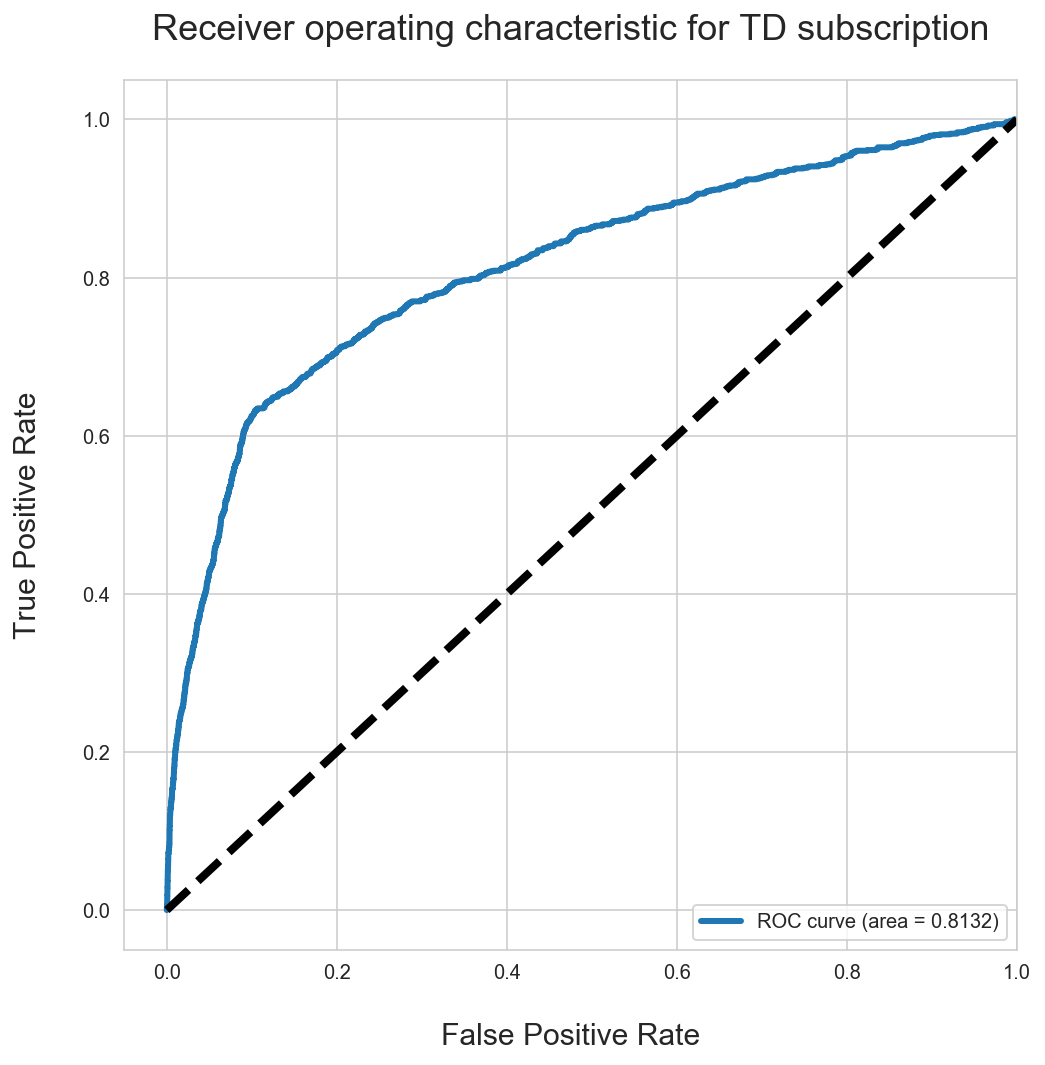

In [167]:
# Plotting the AUC curve to get a sense of the True Positive & False Positive rates at the various cutoffs

rffpr, rftpr, rf_ = roc_curve(y_test, rf_clf_feat.predict_proba(X_test[rf_clf_feature])[:,1])
roc_auc = auc(rffpr, rftpr)

# Plot of a ROC curve
plt.figure(figsize=[8,8])
plt.plot(rffpr, rftpr, label='ROC curve (area = %0.4f)' % roc_auc, linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15, labelpad=20)
plt.ylabel('True Positive Rate', fontsize=15, labelpad=20)
plt.title('Receiver operating characteristic for TD subscription', fontsize=18, pad=20)
plt.legend(loc="lower right")
plt.show()

### <span style="color:steelblue"> Selecting a threshold to use for tuning the model </span>

We are going to try to find the threshold/cut-off at the "elbow" of the ROC-AUC which seems to lie around the 0.1 for False Positive Rate & 0.65 for True Positive Rate.

In [292]:
df_auc = pd.DataFrame({
            "True Positive Rate": rftpr,
            "False Positive Rate": rffpr,
            "Threshold": rf_
        })

df_auc["TPR_diff"] = df_auc["True Positive Rate"].diff()
df_auc["FPR_diff"] = df_auc["False Positive Rate"].diff()

df_auc[(df_auc["True Positive Rate"] > 0.655) & (df_auc["False Positive Rate"] < 0.15)]

,True Positive Rate,False Positive Rate,Threshold,TPR_diff,FPR_diff
881,0.656034,0.137135,0.102985,0.001724,0.000000
882,0.656034,0.139543,0.101509,0.000000,0.002408
883,0.656034,0.139761,0.101504,0.000000,0.000219
884,0.656034,0.140965,0.100823,0.000000,0.001204
885,0.656034,0.141403,0.100808,0.000000,0.000438
886,0.656034,0.142060,0.100707,0.000000,0.000657
887,0.656034,0.142279,0.100696,0.000000,0.000219
888,0.656034,0.142388,0.100596,0.000000,0.000109
889,0.656897,0.142388,0.100562,0.000862,0.000000
890,0.656897,0.142498,0.100540,0.000000,0.000109


In [307]:
# Tuning the threshold/cutoff of the Random Forest Classifier with RFE & checking the confusion matrix

print("Baseline conversion rate:", 1 - baseline)
threshold_matrix(rf_clf_feat, X_test[rf_clf_feature], y_test, threshold=0.098076)

Baseline conversion rate: 0.1126541711178013
Precision based on threshold of 0.098076: 0.3633349123638086
Recall based on threshold of 0.098076: 0.6612068965517242


Predicted,0,1
Actual,,
0,7793,1344
1,393,767


In [306]:
# Trying a higher threshold/cut-off to improve precision and to see the impact on recall

threshold_matrix(rf_clf_feat, X_test[rf_clf_feature], y_test, threshold=0.8)

Precision based on threshold of 0.8: 0.8387096774193549
Recall based on threshold of 0.8: 0.04482758620689655


Predicted,0,1
Actual,,
0,9127,10
1,1108,52


In [311]:
threshold_matrix(rf_clf_feat, X[rf_clf_feature], y, threshold=0.098076)

Precision based on threshold of 0.098076: 0.36708111308466546
Recall based on threshold of 0.098076: 0.6681034482758621


Predicted,0,1
Actual,,
0,31203,5345
1,1540,3100


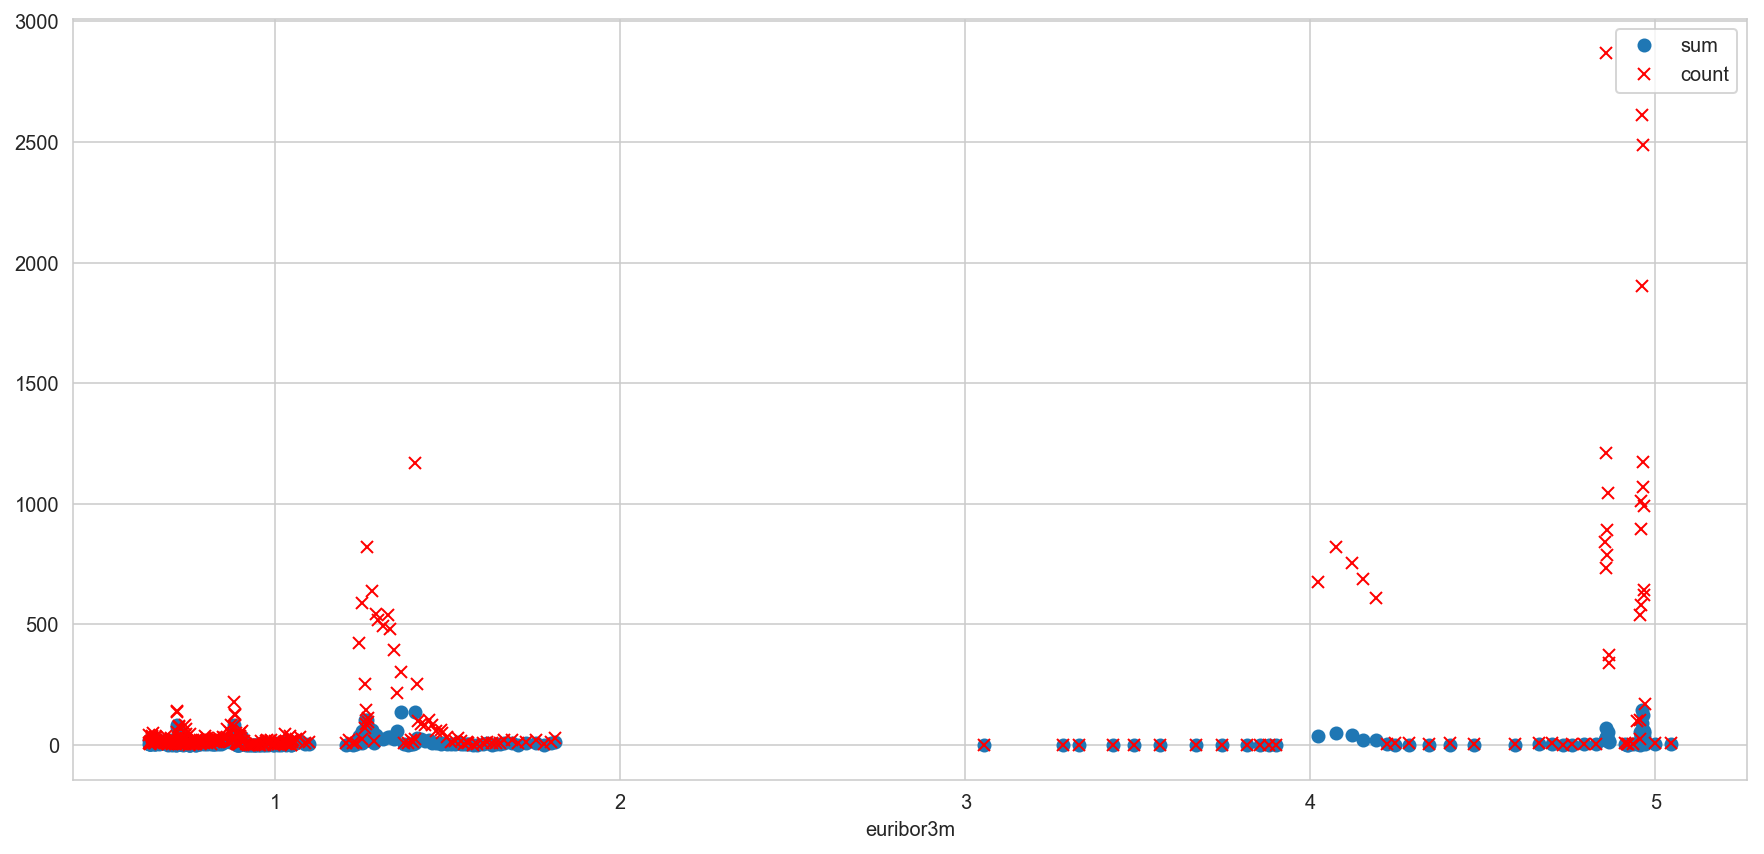

In [289]:
df[['euribor3m', 'y']].groupby('euribor3m')['y'].agg(['sum','count']).plot(style=['o','rx'], figsize=(15,7))

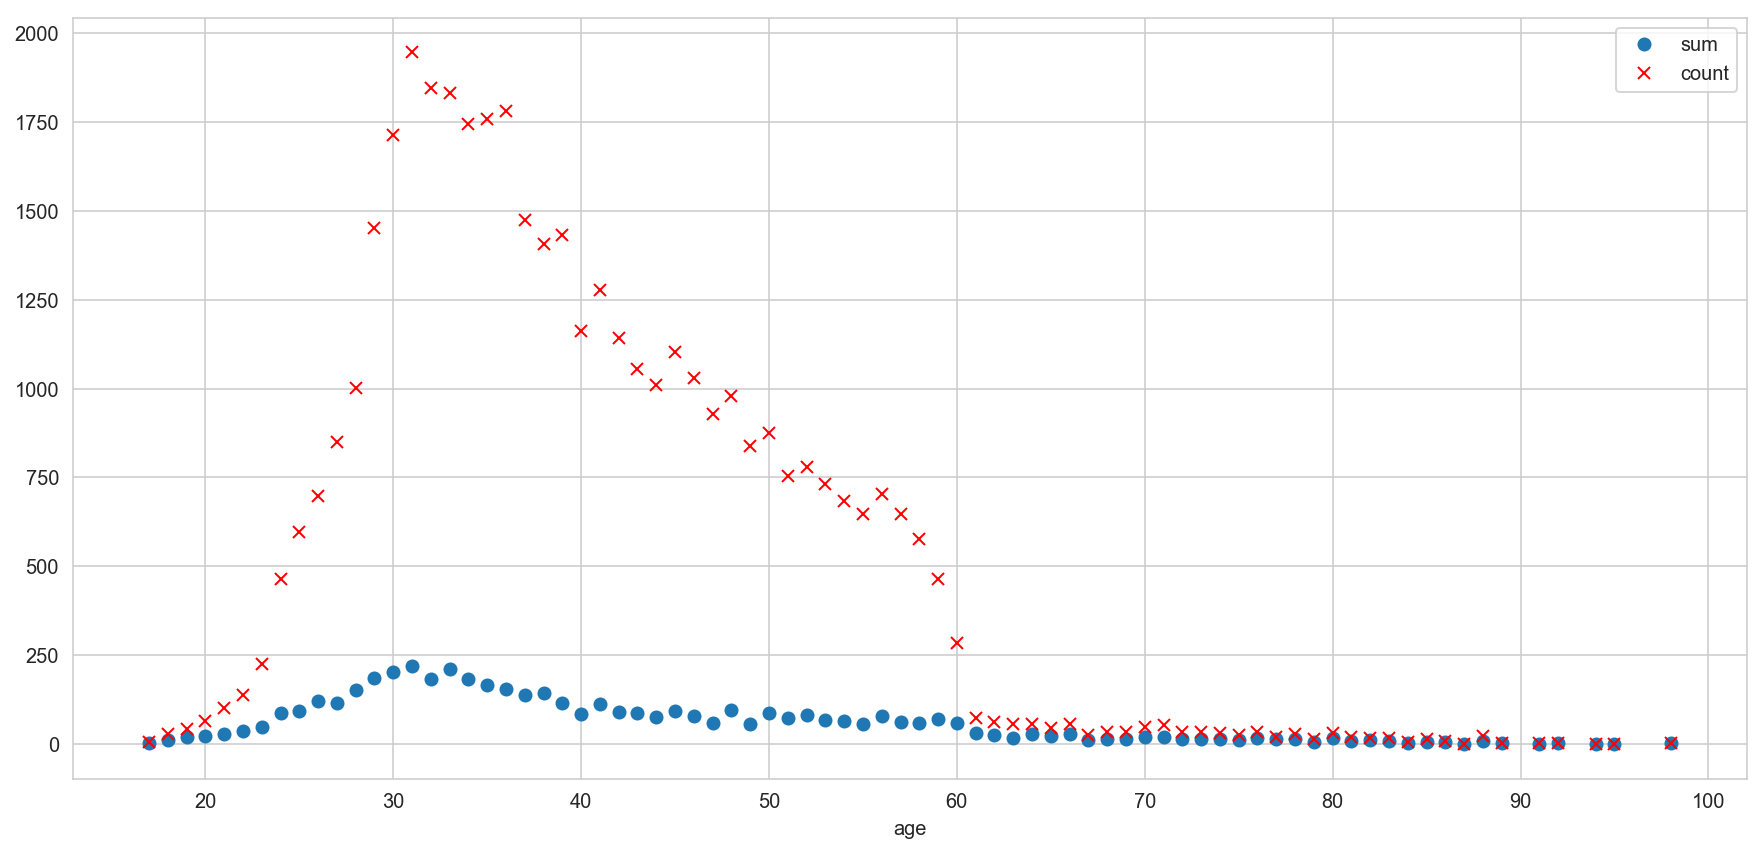

In [290]:
df[['age', 'y']].groupby('age')['y'].agg(['sum','count']).plot(style=['o','rx'], figsize=(15,7))

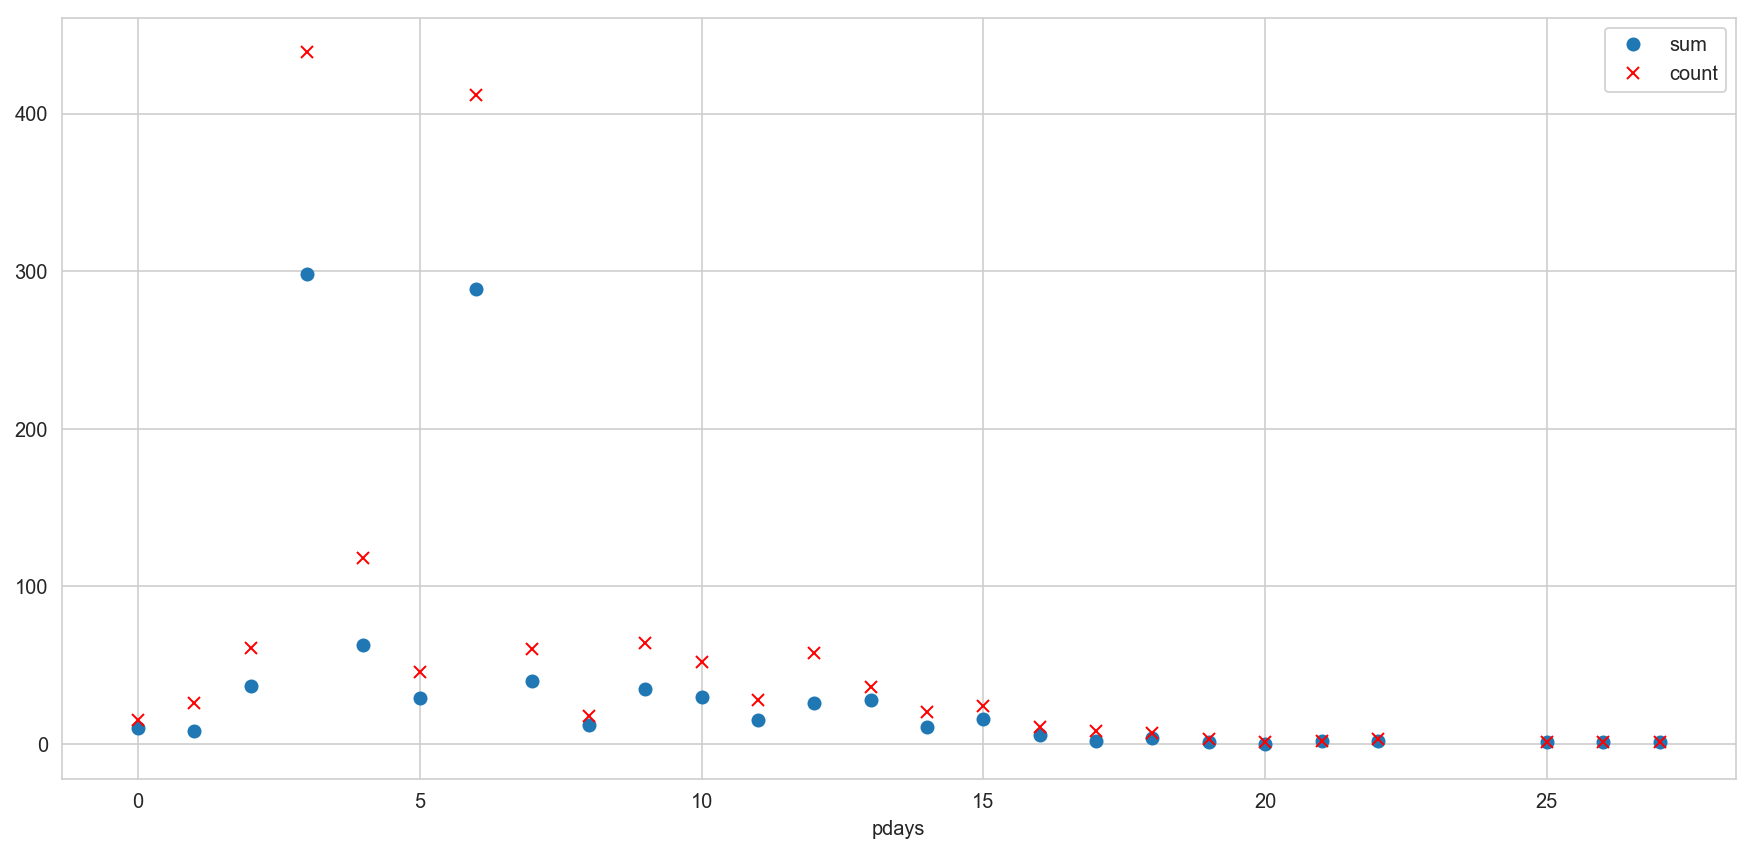

In [291]:
df[df['pdays'] != 999][['pdays', 'y']].groupby('pdays')['y'].agg(['sum','count']).plot(style=['o','rx'], figsize=(15,7))